# Bayesian Multilevel Modelling using PyStan

This is a tutorial, following through Chris Fonnesbeck's [primer on using PyStan with Bayesian Multilevel Modelling](http://mc-stan.org/documentation/case-studies/radon.html).

# 11. Partial Pooling - Group-Level Predictors

In [1]:
%pylab inline

import numpy as np
import pandas as pd
import pystan
import seaborn as sns

import clean_data

sns.set_context('notebook')

Populating the interactive namespace from numpy and matplotlib


/Users/lpritc/Development/GitHub/Teaching/Teaching-Stan-Hierarchical-Modelling/venv-Teaching-Stan-Hierarchical/lib/python3.5/site-packages/Cython/Distutils/old_build_ext.py:30: UserWarning: Cython.Distutils.old_build_ext does not properly handle dependencies and is deprecated.
  "Cython.Distutils.old_build_ext does not properly handle dependencies "


## Group-Level Predictors

One of the strengths of multilevel modelling is that ability to handle predictors that are defined at multiple levels *simultaneously*. For instance, we previously (notebook `08-partial_pooling_varying_intercept.ipynb`) defined the *varying intercept* model to capture county-level variation in prevailing radon concentration:

$$y_i = \alpha_{j[i]} + \beta x_i + \epsilon_i$$

Instead of using a simple *random effect* to describe variation in the expected radon value for each county (as we do here: the parameter $\alpha_{j[i]}$ is drawn from a random distribution), we can specify *another regression model* that has a county-level radon concentration as its covariate, dependent on the county-level uranium measurement $u_j$ - such as:

$$\alpha_j = \gamma_0 + \gamma_1 u_j + \zeta_j$$

Where

* $\alpha_j$: county-level prevailing radon concentration
* $u_j$: the prevailing uranium concentration at county level
* $\gamma_0$: intercept of a linear model relating uranium level to radon level in a county
* $\gamma_1$: slope of a linear model relating uranium level to radon level in a county
* $\zeta_j$: irreducible noise in this relationship, where

$$\zeta_j \sim N(0, \sigma_{\alpha}^2)$$

In this new model, we are incorporating a house-level predictor (floor at which measurement is taken), and a county-level predictor (county uranium level).

### Collinearity

The new model has [indicator (dummy) variables](https://en.wikipedia.org/wiki/Dummy_variable_(statistics)) for each county - $\gamma_0, \gamma_1$ - as well as a county-level covariate $u_j$. In classical regression, this would result in [*(multi)collinearity*](https://en.wikipedia.org/wiki/Multicollinearity): the estimates of the collinear coefficients could vary drastically and still deliver the same fit for the model. In a multilevel model such as this, the partial pooling of coefficients towards expected values of the group-level model avoids this tendency.

Group-level predictors also help to reduce the group-level variation $\sigma_{\alpha}$, which implies that group-level estimates induce a stronger pooling effect.

### Specifying the model

We define the model in `stan`, as usual specifying `data`, `parameters`, `transformed parameters` and `model` blocks. The model is built up as follows.

Our observed log(radon) measurements ($y$) approximate an intermediate transformed parameter $\hat{y}$, which is normally distributed with variance $\sigma_y^2$ (we leave the estimation of $\sigma_y^2$ to `Stan`'s defaults - this is not encouraged by `Stan`'s authors, as the defaults may change between versions!).

$$y \sim N(\hat{y}, \sigma_y^2)$$

The transformed variable $\hat{y}$ is a linear function of $x_i$, the floor at which radon is measured. The parameters are $m_i$, the prevailing log(radon) measurement within the county $i$ ($i=1,\ldots,N$) in which each household is found, and the effect due to which floor is used for measurement, $\beta_2$.

$$\hat{y_i} = m_i + \beta_2 x_i$$

The transformed variable $m_i$ is a linear function of $u_i$, the uranium level in the county. The parameters are the intercept $\alpha_{j[i]}$, drawn from a Normal distribution with mean $\mu_{\alpha}$ and variance $\sigma_{\alpha}^2$, and the effect due to uranium level, $\beta_1$ (we again leave estimation of $\sigma_{\alpha}^2$ to `Stan`'s defaults). The mean $\mu_{\alpha}$ is Normally distributed with mean 0 and unit variance.

$$m_i = \alpha_{j[i]} + \beta_1 u_i$$
$$\alpha_{j[i]} \sim N(\mu_{\alpha}, \sigma_{\alpha}^2)$$
$$\mu_{\alpha} \sim N(0, 1)$$

The values of $\beta_1$ and $\beta_2$ are Normally distributed with mean $0$ and variance $1$. 

$$\beta_1 \sim N(0, 1)$$
$$\beta_2 \sim N(0, 1)$$

In `data`:
* `J` is the number of counties (`int`)
* `N` is the number of samples (`int`)
* `county` is a list of `N` values from 1-85, specifying the county index each measurement
* `u` is a `vector` of uranium levels, in each county
* `x` is a `vector` of indices for which floor the radon measurements were taken at each household
* `y` is a `vector` of log(radon) measurements, one per household/sample.

We define parameters:

* `a` (`vector`, one value per county), representing $\alpha_j[i]$, the county-level intercept for the relationship of county radon level to county uranium level.
* `mu_a`, a `real` corresponding to $\mu_{\alpha}$, the mean radon level underlying the distribution from which the county levels are drawn.
* `sigma_a` is $\sigma_{\alpha}$, the standard deviation of the radon level distribution underlying the county levels: variability of county means about the average.
* `b` (`vector`, two values), representing: $\beta_1$, the slope of the relationship between county-level uranium and radon level; and $\beta_2$, the slope of the relationship between floor measurement and radon level.
* `sigma_y` is $\sigma_y$, the standard deviation of the measurement/sampling error: residual error of the observations.

In [2]:
hierarchical_intercept = """
data {
  int<lower=0> J; 
  int<lower=0> N; 
  int<lower=1,upper=J> county[N];
  vector[N] u;
  vector[N] x;
  vector[N] y;
} 
parameters {
  vector[J] a;
  vector[2] b;
  real mu_a;
  real<lower=0,upper=100> sigma_a;
  real<lower=0,upper=100> sigma_y;
} 
transformed parameters {
  vector[N] y_hat;
  vector[N] m;

  for (i in 1:N) {
    m[i] <- a[county[i]] + u[i] * b[1];
    y_hat[i] <- m[i] + x[i] * b[2];
  }
}
model {
  mu_a ~ normal(0, 1);
  a ~ normal(mu_a, sigma_a);
  b ~ normal(0, 1);
  y ~ normal(y_hat, sigma_y);
}
"""

### Fitting the model

Again, we map Python variables to those in the model, and run the fit:

In [3]:
n_county = clean_data.srrs_mn.groupby('county')['idnum'].count()  # number of samples from each county

hierarchical_intercept_data = {'N': len(clean_data.log_radon),
                               'J': len(n_county),
                               'county': clean_data.county+1, # Stan counts starting at 1
                               'u': clean_data.u,
                               'x': clean_data.floor_measure,
                               'y': clean_data.log_radon}

hierarchical_intercept_fit = pystan.stan(model_code=hierarchical_intercept,
                                         data=hierarchical_intercept_data, 
                                         iter=1000, chains=2)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_09c24493b150e61b5f7babd2ed515f09 NOW.


We can then extract mean estimates for each parameter (and standard deviation for estimate of county-level radon):

In [4]:
g0 = hierarchical_intercept_fit['mu_a'].mean()
g1 = hierarchical_intercept_fit['b'][:, 0].mean()
m_means = hierarchical_intercept_fit['m'].mean(axis=0)
m_se = hierarchical_intercept_fit['m'].std(axis=0)
m_county = hierarchical_intercept_fit['a'].mean(axis=0)

## Interpreting the model output

We can visualise the county-level estimate of radon level as a function of uranium level in the county (i.e. $m_i = \alpha_{j[i]} + \beta_1 u_i$) with a scatterplot:

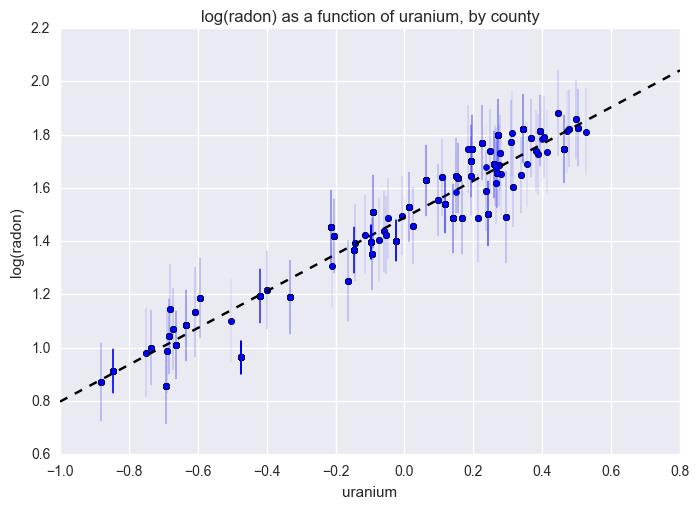

In [5]:
plt.scatter(clean_data.u, m_means)
xvals = np.linspace(-1, 0.8)
plt.plot(xvals, g0 + g1 * xvals, 'k--')  # fitted relationship
for ui, m, se in zip(clean_data.u, m_means, m_se):  # std errors of fitted value
    plt.plot([ui, ui], [m - se, m + se], 'b-',
             linewidth=0.2, alpha=0.2)

# presentation
plt.xlim(-1, 0.8)
plt.title("log(radon) as a function of uranium, by county")
plt.xlabel("uranium")
plt.ylabel("log(radon)");

The black dashed line indictes the inferred relationship between uranium level and prevailing radon level in the county. The intensity of the vertical line indicates sample size in that county.

These standard errors are narrower than for the partial-pooling models that do not contain a county-level covariate for uranium, implying that we may have improved the accuracy of our estimates of prevailing log(radon) level by county.